In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# FastICA Code

## Implementation of the algorithm

Function to perform 'Centering' and 'Whitening' step

In [40]:
# This function assumes as input a matrix X with samples on columns
def preprocessing(X, n_sources, under_complete = False):
    # Centering step
    X_mean = np.mean(X, axis = 1)               # Samples on columns
    X_bar = X - X_mean[:, None]
 

    # PCA Dimensionality reduction
    U, s, VT = np.linalg.svd(X_bar, full_matrices = False)

    # If the number of sources is less than the number of mixtures we perform dimensionality reduction
    # and keep only the first n_sources principal components (under-complete ICA)
    if under_complete:
        if (n_sources < X.shape[0]):
            T = U[:, :n_sources].T @ X_bar              # First 'n_sources' Principal components    
            print("Reduced dimensionality")
        else:
            T = U.T @ X_bar
    else:
        T = U.T @ X_bar                     


    # Scaling / Normalization step
    T_std = np.std(T, axis = 1) 
    T_norm = (T) / T_std[:, None]

    return T_norm

Fast ICA algorithm

In [41]:
# This function assumes as input a matrix X with samples on columns, automatically performs the preprocessing step
def FastIca(mixture_signals, n_sources, n_iter = 5000, tol = 1e-9, under_complete = True):
    # Preprocessing step
    X = preprocessing(mixture_signals, n_sources, under_complete = under_complete)

    # Number of mixtures
    n_mixtures = X.shape[0]
    # Number of samples
    n_samples = X.shape[1]

    # Initialize a random weight Matrix with unit varinace
    W = np.random.rand(n_mixtures, n_sources) 
    W_std = np.std(W, axis = 1) 
    W = (W) / W_std[:, None]


    # FastICA algorithm
    for p in range(n_sources):
        w_p = W[:, p]                           # recover the p-th row of W

        for i in range(n_iter):                 # Computing a single independent component
            w_p_old = w_p

            y = w_p.T @ X                       # Argument of g
            # Computing the fisrt derivative  
            g = y*np.exp(-y**2/2)   
            # g = np.tanh(y)       

            # Computing the second derivative
            g_prime = (1 - y**2)*np.exp(-y**2/2)
            # g_prime = 1 - np.tanh(y)**2

            # Update rule
            w_p = X @ g.T / n_samples - np.mean(g_prime)*w_p

            # Orthogonalization step
            w_p = w_p - W[:, :p] @ W[:, :p].T @ w_p

            # Method 2 for orthogonalization
            # for k in range(p):
            #      w_p = w_p - np.dot(W[:, k], w_p) * W[:, k]

            # Normalization step
            w_p = w_p / np.linalg.norm(w_p)

            # Convergence criterion
            if (np.linalg.norm(w_p - w_p_old) < tol):
                break
        
        W[:, p] = w_p
    
    # Recovering the sources
    S = W.T @ X
    return S, W     

In [42]:
# Function to plot the signals
def print_signals(S, title, labels = False, scaling = 1): 
    # Plotting the signals
    plt.figure(figsize=(20, 6))

    if labels:
        for i in range(S.shape[0]):
            plt.plot(t, S[i], label = "s"+str(i+1), linewidth = 4)
    else:
        for i in range(S.shape[0]):
            plt.plot(t, S[i], linewidth = 4)

    plt.title(title, fontsize = 20)
    plt.xlabel("t")
    plt.ylabel("Amplitude")

    # Setting limits for the axes
    plt.xlim(0, 20)
    plt.ylim(-1*scaling, 1*scaling)

    if labels:
        plt.legend()

## Example

Here we have an example

Here we generate 3 random singnals


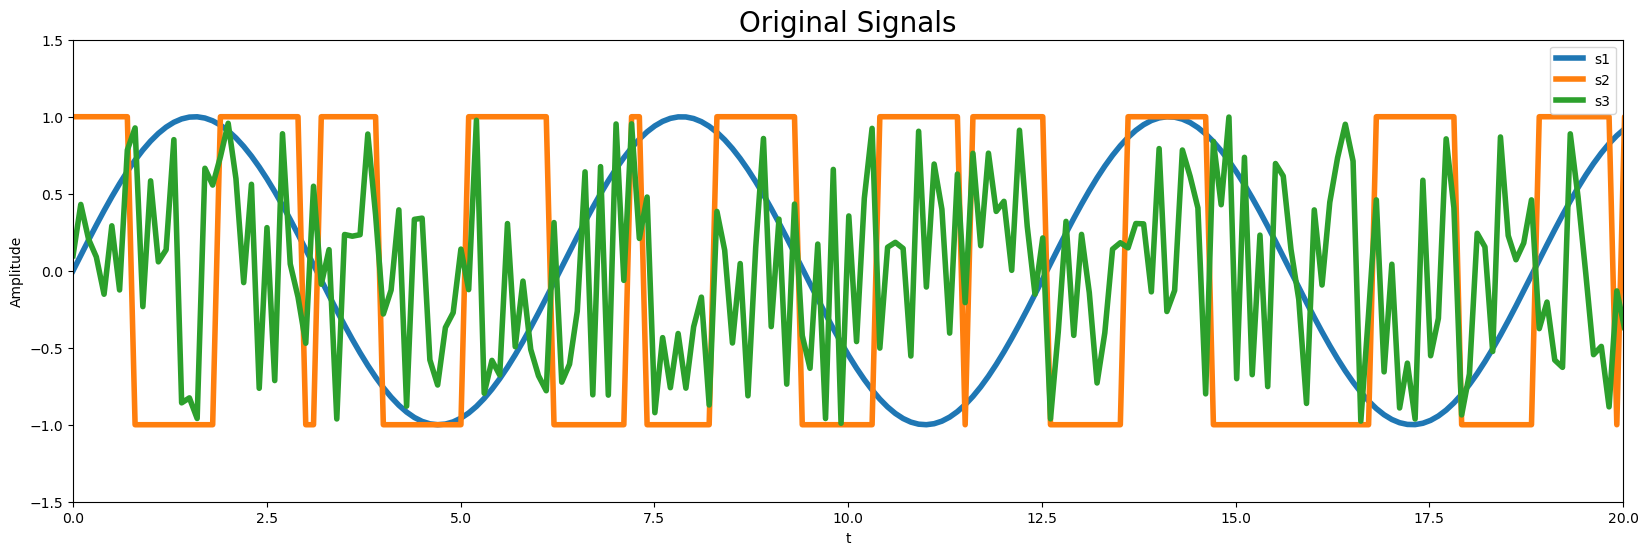

In [43]:
# Samples
n_samples = 1000
t = np.linspace(0, 100, n_samples)

# Seed for reproducibility
np.random.seed(0)

# Generate 3 signals
s1 = np.sin(t)                                          # Sine wave                            
s2 = np.sign((np.cos(t*2.2) + np.sin(t*3.7)))           # Square wave
s3 = np.random.uniform(-1, 1, n_samples)                # Random uniform noise

# Sources
S = np.array([s1, s2, s3])


# Plotting the signals
print_signals(S, "Original Signals", labels = True, scaling = 1.5)

Here we build a mixing matrix and mix the signals

(0.0, 30.0)

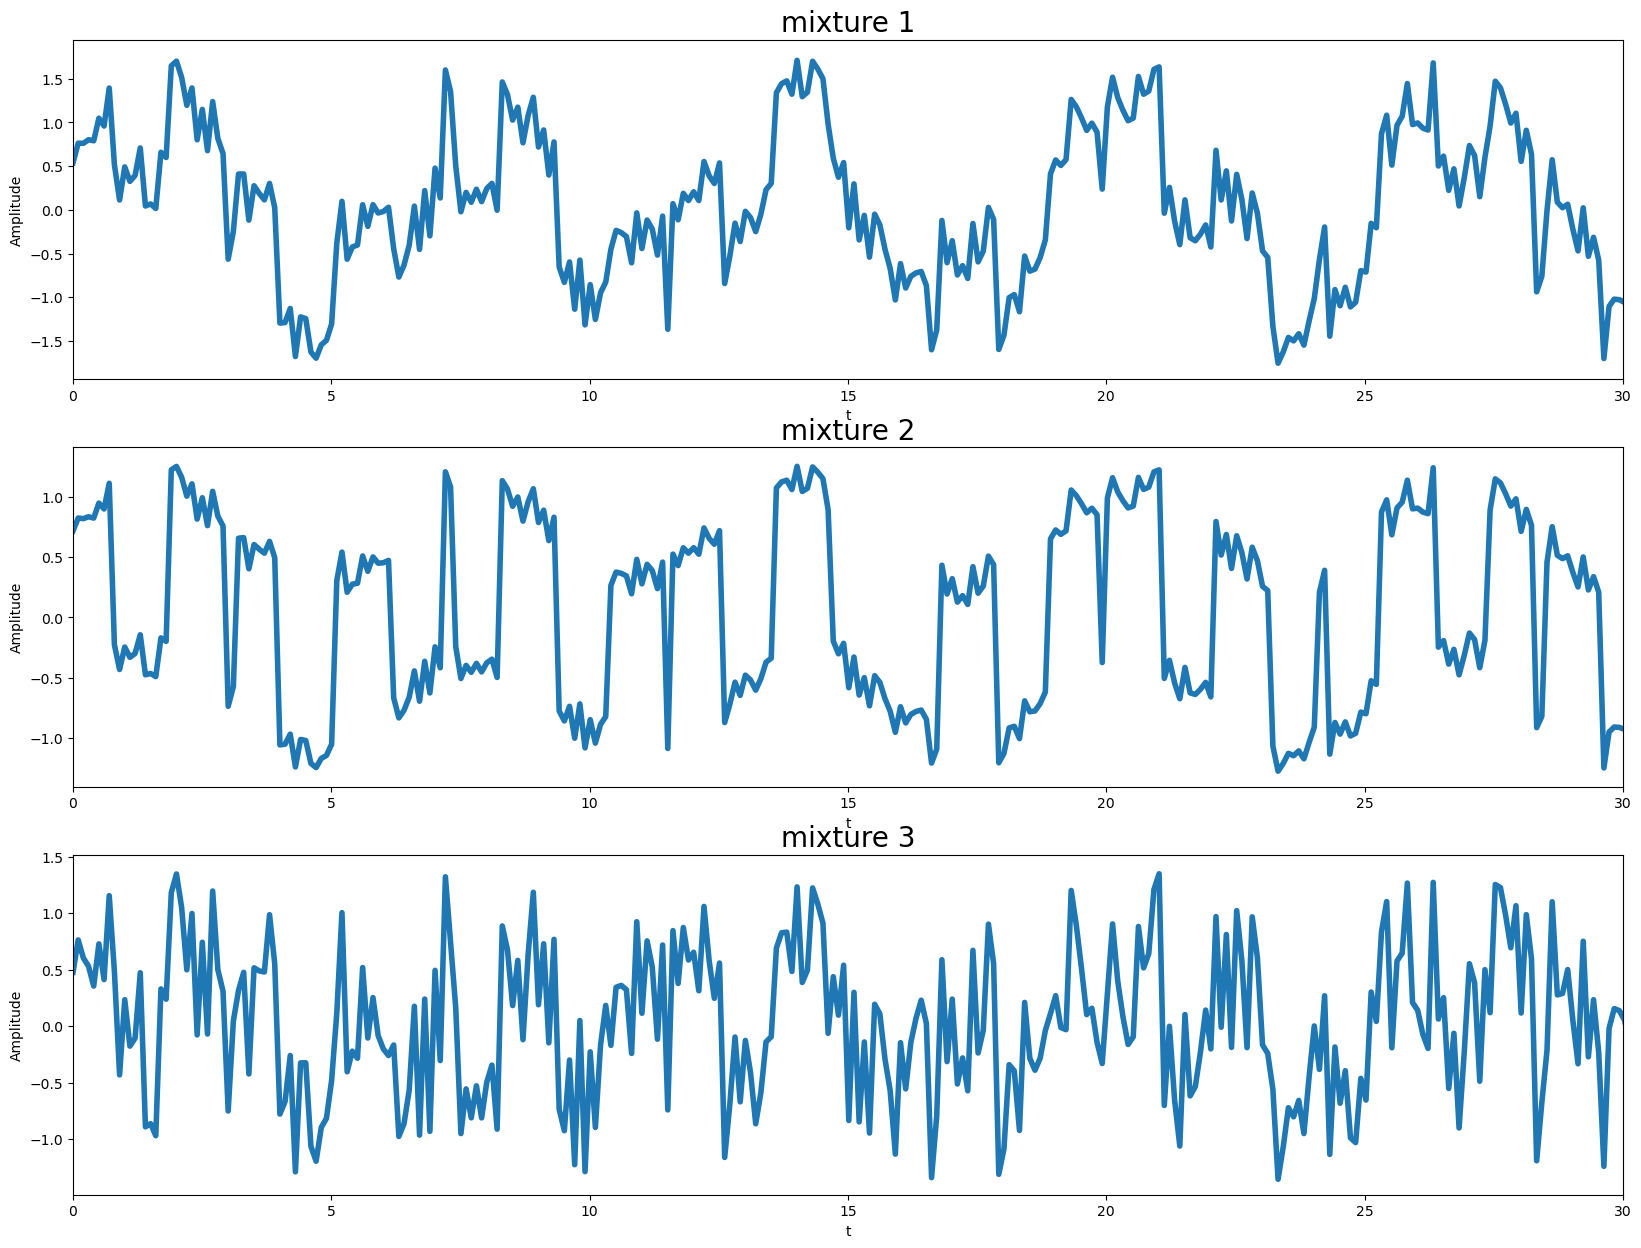

In [44]:
# # Mixing matrix
A = np.array([[0.9, 0.5, 0.4],
              [0.4, 0.7, 0.2],
              [0.2, 0.4, 0.8]])


# Mixed signals
X = A @ S

# Plotting the mixed signals
fig, axs = plt.subplots(nrows=3, ncols=1, figsize = (20, 15))
axs = axs.flatten()

axs[0].plot(t, X[0], linewidth = 4)     
axs[0].set_title('mixture 1', fontsize = 20)
axs[0].set_xlabel("t")
axs[0].set_ylabel("Amplitude")

axs[1].plot(t, X[1], linewidth = 4)     
axs[1].set_title('mixture 2', fontsize = 20)
axs[1].set_xlabel("t")
axs[1].set_ylabel("Amplitude")

axs[2].plot(t, X[2], linewidth = 4)     
axs[2].set_title('mixture 3', fontsize = 20)
axs[2].set_xlabel("t")
axs[2].set_ylabel("Amplitude")

# Setting limits for the axes
axs[0].set_xlim(0, 30)
axs[1].set_xlim(0, 30)
axs[2].set_xlim(0, 30)


In [45]:
# Recovering the signals
S_recovered, W = FastIca(X, 3)

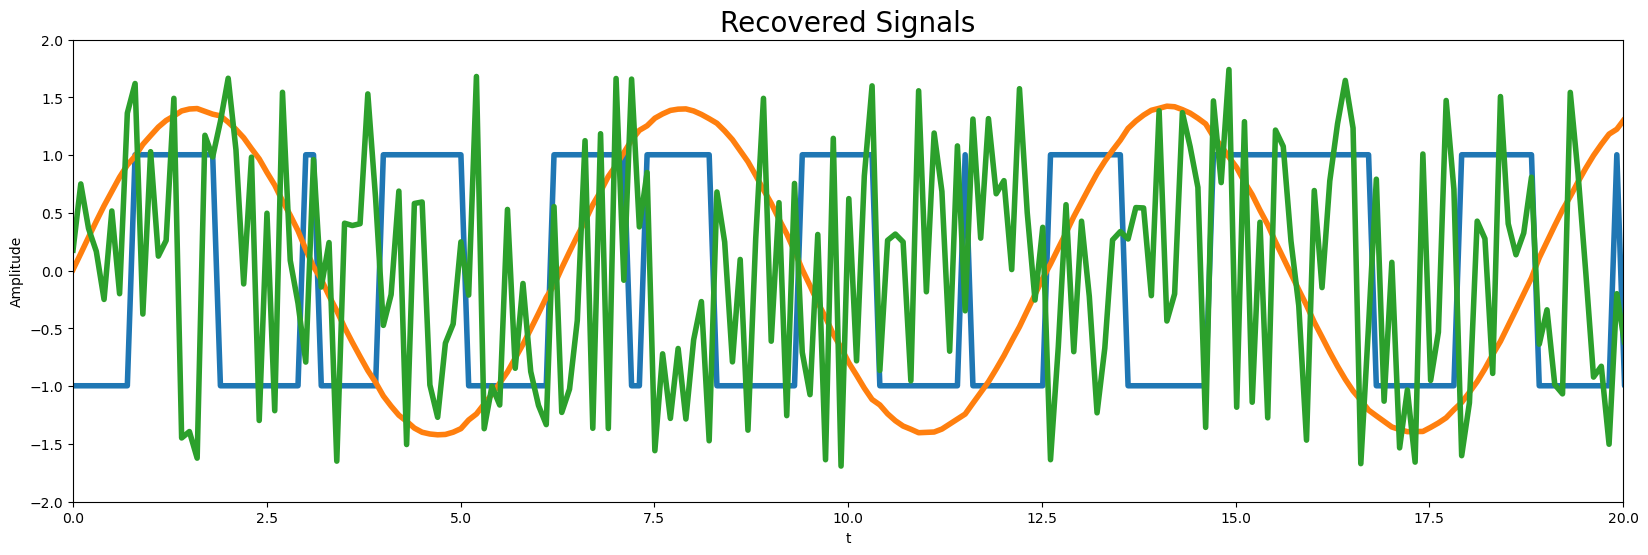

In [46]:
print_signals(S_recovered, "Recovered Signals", labels = False, scaling = 2)

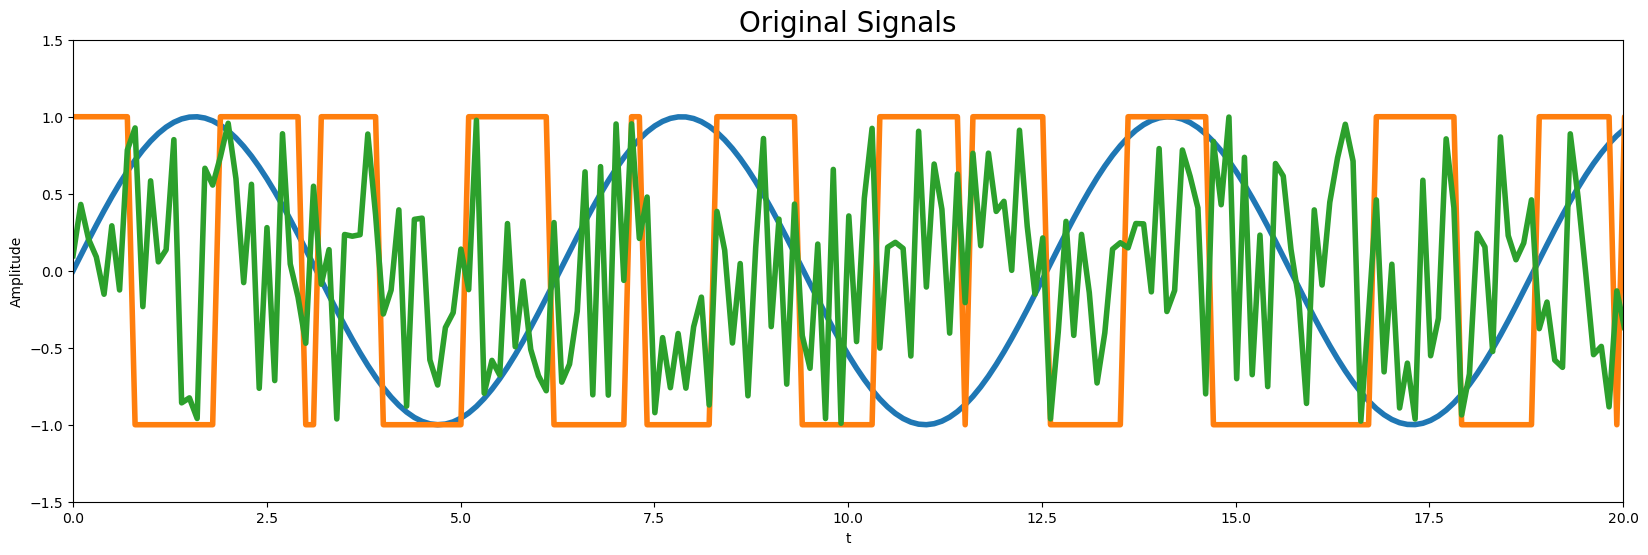

In [47]:
print_signals(S, "Original Signals", labels = False, scaling = 1.5)

As we can see ICA recovers some of the original signals with swapped sign, this is becouse the sources are independent and the mixing process is linear, the same sources can be recovered with different signs or orders. This ambiguity arises because multiplying a source by -1 does not change its independence or the linear mixing process.

## Other Examples

### 4 Signals

In this example we see how the algorithm above behave when applied to a mixture of 4 signals

In [48]:
# Samples
n_samples = 10000
t = np.linspace(0, 1000, n_samples)

# Generate 4 signals
s1 = np.sin(t)                                          # Sine wave                            
s2 = np.sign((np.cos(t*2.2) + np.sin(t*3.7)))           # Square wave
s3 = np.cos(t*0.6)                                      # Cosine
s4 = signal.sawtooth(t*2.1).squeeze()                   # Sawtooth wave  


# Sources
S = np.array([s1, s2, s3, s4])


# # Mixing matrix
A = np.array([[0.9, 0.5, 0.4, 0.6],
              [0.4, 0.7, 0.2, 0.3],
              [0.2, 0.4, 0.8, 0.5],
              [0.3, 1, 0.2, 0.9]])


# Mixed signals
X = A @ S


# FastICA
S_recovered, W = FastIca(X, 4)

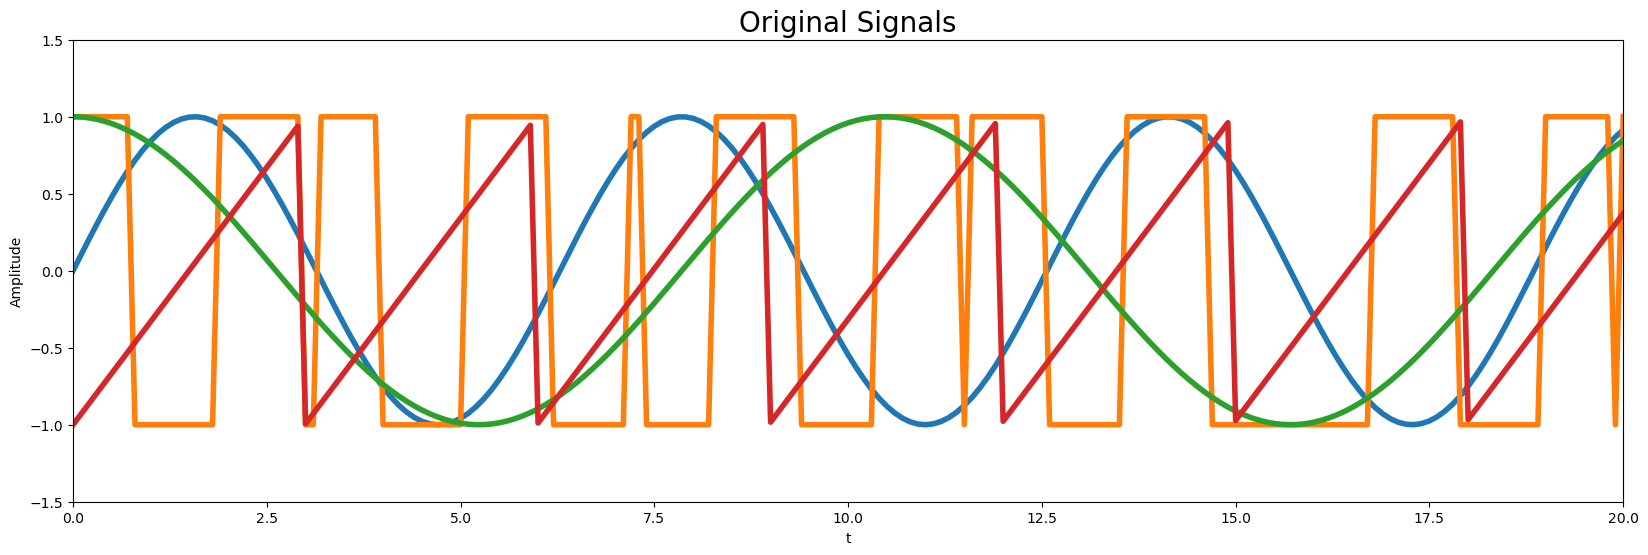

In [49]:
print_signals(S, "Original Signals", labels = False, scaling = 1.5)

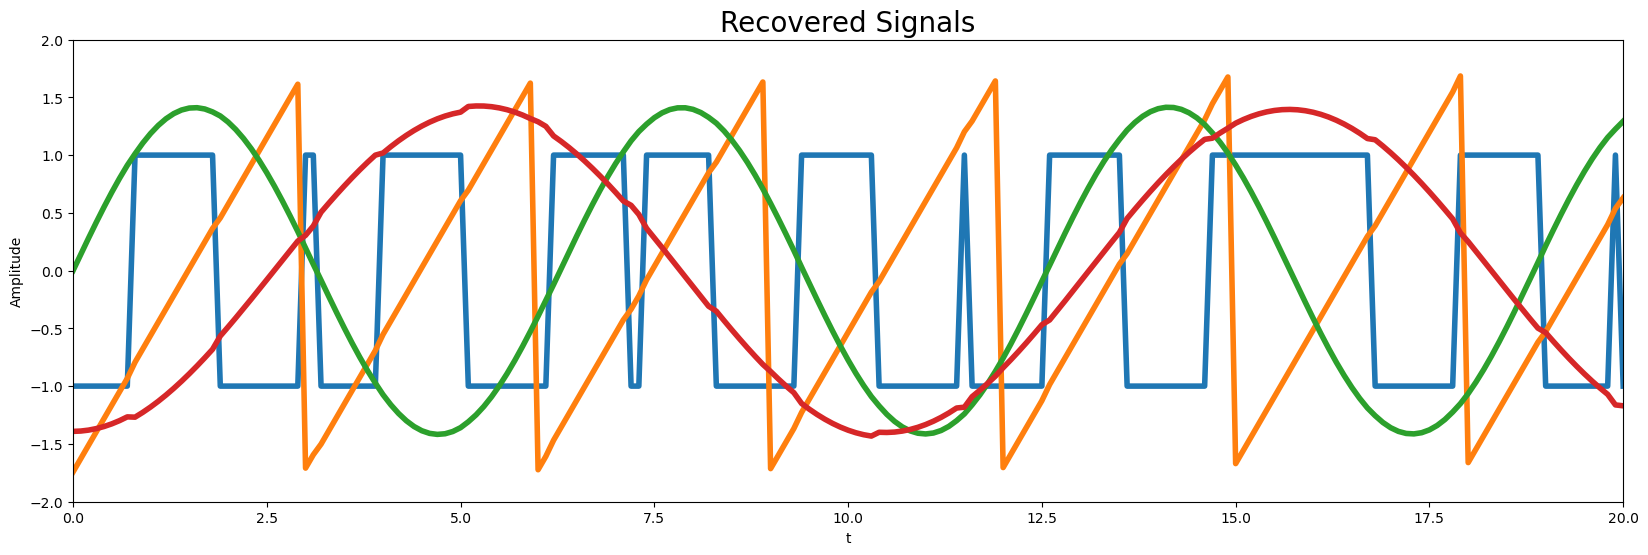

In [50]:
print_signals(S_recovered, "Recovered Signals", labels = False, scaling = 2)

### Undercomplete ICA

Here we can see how dimensionality reduction affects the under complete case (i.e more mixtures then sources)

In [51]:
# Samples
n_samples = 10000
t = np.linspace(0, 1000, n_samples)

# Generate 4 signals
s1 = np.sin(t)                                          # Sine wave                            
s2 = np.sign((np.cos(t*2.2) + np.sin(t*3.7)))           # Square wave
s3 = signal.sawtooth(t*2.1).squeeze()                   # Sawtooth wave  


# Sources
S = np.array([s1, s2, s3])


# # Mixing matrix
A = np.array([[0.9, 0.5, 0.4],
              [0.4, 0.7, 0.2],
              [0.2, 0.4, 0.8],
              [0.3, 1, 0.2]])


# Mixed signals
X = A @ S


# FastICA
S_recovered_undercomplete, W = FastIca(X, 3, under_complete = True)
S_recovered, W = FastIca(X, 3, under_complete = False)

Reduced dimensionality


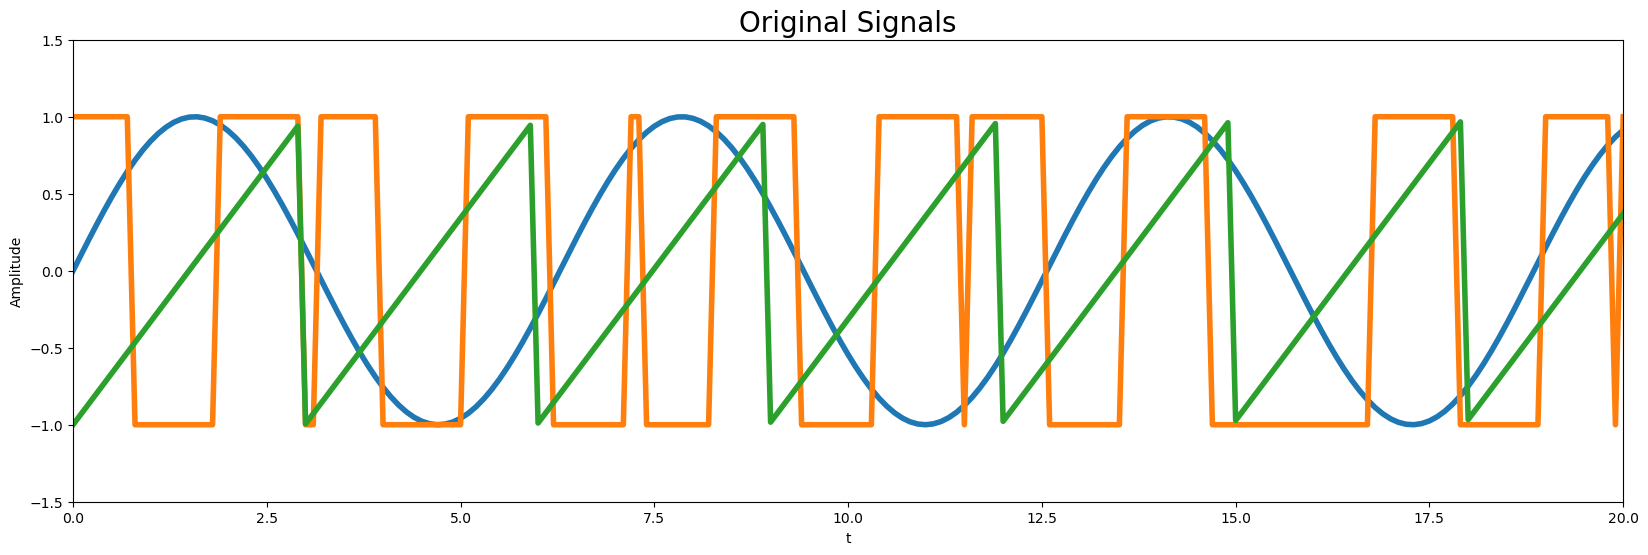

In [52]:
print_signals(S, "Original Signals", labels = False, scaling = 1.5)

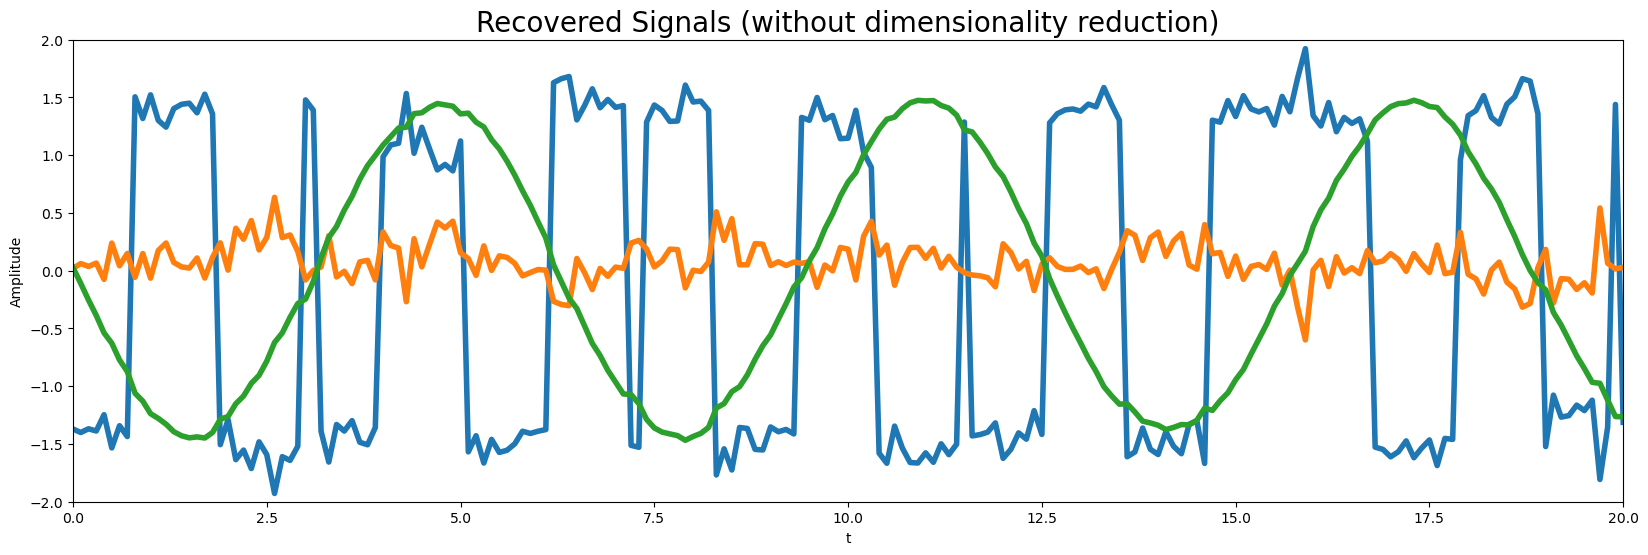

In [53]:
print_signals(S_recovered, "Recovered Signals (without dimensionality reduction)", labels = False, scaling = 2)

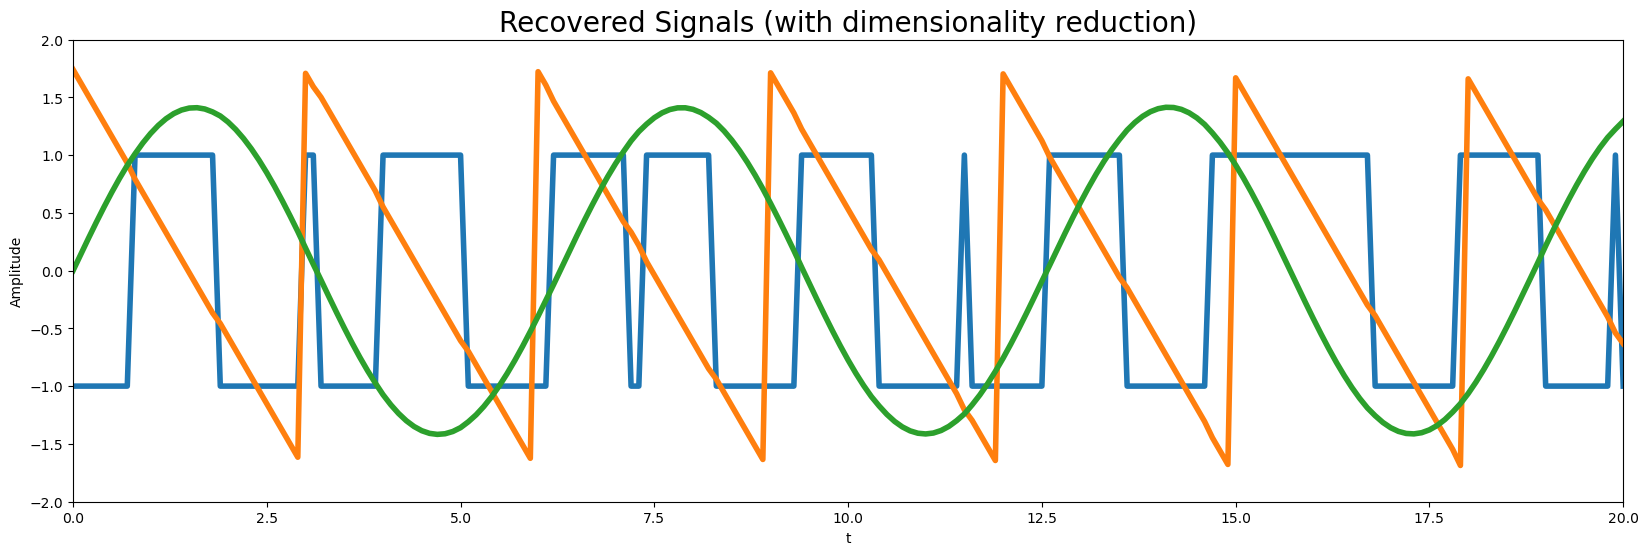

In [54]:
print_signals(S_recovered_undercomplete, "Recovered Signals (with dimensionality reduction)", labels = False, scaling = 2)